<a href="https://colab.research.google.com/github/Davjot/PlantDoc/blob/main/SE_RAM_DN201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , TensorBoard
from tensorflow.keras.layers import Reshape, multiply, add, Conv2D, MaxPooling2D, BatchNormalization, Activation, ZeroPadding2D, AveragePooling2D

In [37]:
# Set the batch size
batch_size = 32

# Set the number of epochs
epochs = 50

# Set the image size
img_size = 224

# Set the number of classes
num_classes = 8

In [38]:
# Define the data generator for preprocessing the images
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split = 0.2)
#if necessary add validation_split factor =0.2
#val_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import os
base_dir = '/content/drive/MyDrive/Plantdoc'
train_dir = os.path.join(base_dir)
#validation_dir = os.path.join(base_dir)

In [41]:
train_apple_rust_leaf_dir = os.path.join(train_dir, 'Apple rust leaf')
# validation_apple_rust_leaf_dir = os.path.join(validation_dir, 'Apple rust leaf')
train_blueberry_leaf_dir = os.path.join(train_dir, 'Blueberry leaf')
# validation_blueberry_leaf_dir = os.path.join(validation_dir, 'Blueberry leaf')
#train_apple_rust_leaf_fnames = os.listdir(train_apple_rust_leaf_dir) 
#training set
train_apple_leaf_dir = os.path.join(train_dir, 'Apple leaf')
train_apple_scab_leaf_dir = os.path.join(train_dir, 'Apple scab leaf')
train_bell_pepper_leaf_dir = os.path.join(train_dir, 'Bell pepper leaf')
train_bell_pepper_leaf_spot_dir = os.path.join(train_dir, 'Bell pepper leaf spot')
train_cherry_leaf_dir = os.path.join(train_dir, 'Cherry leaf')
train_corn_gray_leaf_spot_dir = os.path.join(train_dir, 'Corn Gray leaf spot')

#validation set
# validation_apple_leaf_dir = os.path.join(validation_dir, 'Apple leaf')
# validation_apple_scab_leaf_dir = os.path.join(validation_dir, 'Apple scab leaf')
# validation_bell_pepper_leaf_dir = os.path.join(validation_dir, 'Bell pepper leaf')
# validation_bell_pepper_leaf_spot_dir = os.path.join(validation_dir, 'Bell pepper leaf spot')
# validation_cherry_leaf_dir = os.path.join(validation_dir, 'Cherry leaf')
# validation_corn_gray_leaf_spot_dir = os.path.join(validation_dir, 'Corn Gray leaf spot')

In [42]:
# Load the training set
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

Found 64 images belonging to 8 classes.


In [43]:
# Load the validation set
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 16 images belonging to 8 classes.


In [44]:
# Load the DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [45]:
# Add SE mechanism
def squeeze_excite_block(input, ratio=16):
    init = input
    channel_axis = 3

    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)(se)

    x = multiply([input, se])
    return x

In [46]:
# Add Residual Attention Mechanism
def RAM(input, filters):
    # First RAM layer
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second RAM layer
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third RAM layer
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Residual connection
    shortcut = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(input)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    # Squeeze-and-Excite mechanism
    x = squeeze_excite_block(x)

    # Final RAM layer
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    # Squeeze-and-Excite mechanism
    x = squeeze_excite_block(x)

    return x

In [47]:
# Add the Residual Attention Mechanism to the DenseNet201 model
x = base_model.output
x = RAM(x, 192)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # change the dropout to 0.2 later 
output = Dense(num_classes, activation='softmax')(x)

In [48]:
model = Model(inputs=base_model.input, outputs=output)

In [49]:
# Set the layers of the DenseNet201 model to be non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [50]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

the model checkpoints will be saved with the epoch number and the validation loss in the filename. The directory of the filepath should not be reused by any other callbacks to avoid conflicts.

In [51]:
# Define the checkpoint and early stopping and tensorboard callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/modelcheckpoint_dn201', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
log_dir = TensorBoard(log_dir = '/content/drive/MyDrive/logdir_dn201')

In [52]:
# Train the model
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    #verbose = 2,
                    callbacks=[checkpoint, early_stopping, log_dir])

Epoch 1/50
2/2 [==============================] - 49s 19s/step - loss: 2.2704 - accuracy: 0.1406 - val_loss: 2.1634 - val_accuracy: 0.1250
Epoch 2/50
2/2 [==============================] - 31s 18s/step - loss: 2.2648 - accuracy: 0.1406 - val_loss: 2.1582 - val_accuracy: 0.0625
Epoch 3/50
2/2 [==============================] - 26s 14s/step - loss: 2.2271 - accuracy: 0.1719 - val_loss: 2.0919 - val_accuracy: 0.1875
Epoch 4/50
2/2 [==============================] - 26s 13s/step - loss: 2.0138 - accuracy: 0.1875 - val_loss: 2.1683 - val_accuracy: 0.0625
Epoch 5/50
2/2 [==============================] - 25s 13s/step - loss: 2.0302 - accuracy: 0.1875 - val_loss: 2.1151 - val_accuracy: 0.1250
Epoch 6/50
2/2 [==============================] - 25s 14s/step - loss: 2.1004 - accuracy: 0.2344 - val_loss: 2.1385 - val_accuracy: 0.0625
Epoch 7/50
2/2 [==============================] - 26s 14s/step - loss: 1.9232 - accuracy: 0.3281 - val_loss: 2.0143 - val_accuracy: 0.1250
Epoch 8/50
2/2 [===========

In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [55]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [56]:
# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

In [57]:
# Get number of epochs
epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

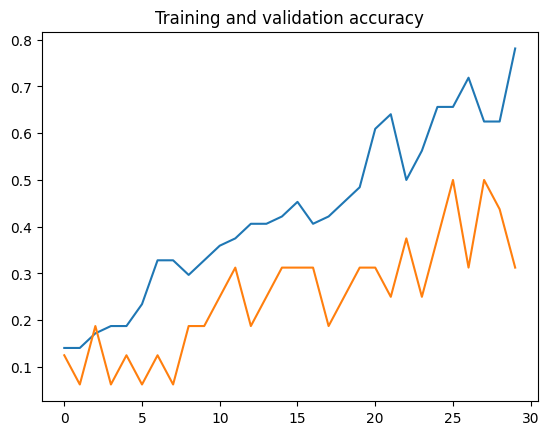

<Figure size 640x480 with 0 Axes>

In [58]:
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

<Figure size 640x480 with 0 Axes>

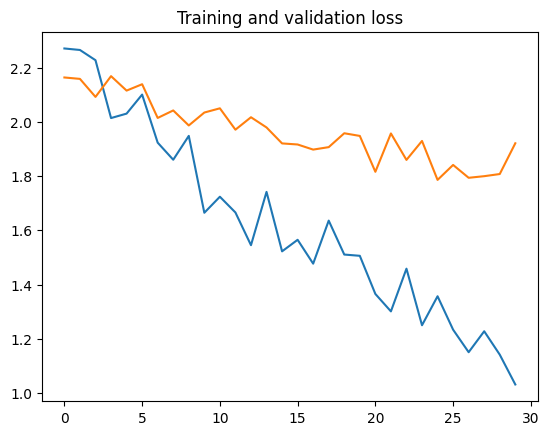

<Figure size 640x480 with 0 Axes>

In [59]:
# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.figure()

In [53]:
# Save the model
#model.save('path/to/save/model')